In [1]:
import numpy as np
import pandas as pd
import os
import tifffile
import cv2
from os.path import join, isfile, exists
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
import os
from PIL import Image
import re
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import copy
import warnings
import contextlib
from datetime import datetime


/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_condition(title):
    # Load the Excel file into a DataFrame
    df = pd.read_excel('../fig5_tile_conditions.xlsx')

    # Filter the DataFrame based on the given parameters
    filtered_df = df[(df['Experiment'].dt.day == int(title.split('_')[0])) & (df['Tile'] == int(title.split('_')[1]))]

    # Check if there are any matching rows
    if len(filtered_df) > 0:
        # Retrieve the condition from the first matching row
        condition = filtered_df.iloc[0]['Condition']
        return condition
    else:
        return None

In [3]:
# Define the dataset class
class MyDataset(Dataset):
    def __init__(self, root_dir, transform=None, timestamp=1):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        label_map 
        for folder in os.listdir(root_dir):
            folder_path = os.path.join(root_dir, folder)
            files = [f for f in os.listdir(folder_path) if isfile(join(folder_path, f))]
            label = get_condition(folder)
            # print(folder_path, label)
            for file in files:
                file_path = os.path.join(folder_path, file)
                match = re.search(r'_t(\d+)_c002', file)
                if match:
                    number = int(match.group(1))
                    if number == timestamp:
                        # print(file)
                        if file_path.endswith(".png"):
                            img = Image.open(file_path).convert("RGB")
                            name = file.split("_")[0]
                            label = label_map.get(label, -1)
                            if label != -1:
                                self.images.append(img)
                                self.labels.append(label)
                            # self.labels.append(lable_map[name])
                        elif file_path.endswith(".tif"):
                            # here are the reading of tif files                        
                            try:
                                image_array = tifffile.imread(file_path)
                            except TypeError:
                                pass
                                # print(e)
                            img_rescaled = 255 * (image_array - image_array.min()) / (image_array.max() - image_array.min())
                            # dont think this is necessary, can be commented out                             
                            # img_col = cv2.applyColorMap(img_rescaled.astype(np.uint8), cv2.COLORMAP_DEEPGREEN)
                            img = Image.fromarray(img_rescaled)
                            img = img.convert("RGB")
                            name = file.split("_")[0]
                            label = label_map.get(label, -1)
                            if label != -1:
                                self.images.append(img)
                                self.labels.append(label)
                            break
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        # apply transformation         
        if self.transform is not None:
            img = self.transform(img)
        return img, label


In [4]:
def train_model(model, criterion, optimizer, dataloaders, num_epochs=25, debug=False):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_values = []
    for epoch in range(num_epochs+1):
        if epoch % 5 == 0 and debug:
            print(f'Epoch {epoch}/{num_epochs}')
            
    
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            total = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += (preds == labels).sum().item()
                total += labels.size(0)

            epoch_loss = running_loss / len(dataloaders[phase])
            loss_values.append(epoch_loss)
            epoch_acc =  running_corrects / total
            if epoch % 5 == 0 and debug:
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')   
                

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        if epoch % 5 == 0 and debug:  
            print('-' * 10)

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_values

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
def get_metrics(model, test_dataloader):
    true_labels = []
    predicted_labels = []
    accuracy_values = []
    correct = 0
    total = 0
    model.eval()

    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)

            # true_labels.extend(labels.numpy())
            # predicted_labels.extend(predicted.numpy())
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    accuracy = accuracy_score(true_labels, predicted_labels)
    # print(f"accuracy: {accuracy}")
    # print(f"Precision: {precision}")
    # print(f"Recall: {recall}")
    # print(f"F1 Score: {f1}")
    return accuracy, precision, recall, f1


In [6]:
label_map = {"BMP4" :0, "CHIR": 1, "DS": 2, "DS+CHIR": 3,  "WT": 4}
# Define the input shape of the images
input_shape = (3, 224, 224)
# Define the number of classes
num_classes = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = models.googlenet(pretrained=True)

cuda


/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# Define the data transformations
transform = transforms.Compose([
    transforms.Resize(input_shape[1:]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
# Load the dataset
def get_dataloaders(time):
    dataset = MyDataset("../../images", transform=transform, timestamp=time)
    train_dataset, val_test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
    validation_dataset, test_dataset = train_test_split(val_test_dataset, test_size=0.5, random_state=42)
    # Create data loaders for train and test sets
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size=8, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)
    dataloaders = {'train': train_dataloader, 'val': validation_dataloader, 'test': test_dataloader}
    return dataloaders

In [8]:
# freezed model
for param in model.parameters():
    param.requires_grad = False
# # # Remove the last fully connected layer
model.fc = nn.Identity()
model.fc.requires_grad = True
# Replace the last fully connected layer with a new layer that has `num_classes` output units
model.fc = nn.Linear(1024, num_classes)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
model = model.to(device)

In [9]:
# unfreezed model
# model.fc = nn.Linear(model.fc.in_features, num_classes)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
# model = model.to(device)

In [10]:
import sys
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
original_stderr = sys.stderr
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
current_date = datetime.now().strftime('%Y-%m-%d')
save_dir = os.path.join("saved_models/tl", current_date)
os.makedirs(save_dir, exist_ok=True)
num_epochs = 10
sys.stderr = open(os.devnull, 'w')
for timestamp in range(1, 290):
# for timestamp in range(1, 10):
    print("timestamp: ", timestamp)
    dataloaders = get_dataloaders(timestamp)
    model_trained, loss_values = train_model(model, criterion, optimizer, dataloaders, num_epochs=num_epochs)
    model_filename = os.path.join(save_dir, f"model_{timestamp}_epochs{num_epochs}.pt")
    torch.save(model_trained.state_dict(), model_filename)

    accuracy, precision, recall, f1 = get_metrics(model_trained, dataloaders['test'])
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    print("Accuracy: ", accuracy)
    recall_list.append(recall)
    f1_list.append(f1)
sys.stderr = original_stderr

timestamp:  1
Training complete in 0m 2s
Best val Acc: 0.500000
Accuracy:  0.875
timestamp:  2
Training complete in 0m 1s
Best val Acc: 0.625000
Accuracy:  0.875
timestamp:  3
Training complete in 0m 1s
Best val Acc: 0.750000
Accuracy:  0.75
timestamp:  4
Training complete in 0m 1s
Best val Acc: 0.625000
Accuracy:  0.875
timestamp:  5
Training complete in 0m 1s
Best val Acc: 0.625000
Accuracy:  0.875
timestamp:  6
Training complete in 0m 1s
Best val Acc: 0.750000
Accuracy:  0.625
timestamp:  7
Training complete in 0m 1s
Best val Acc: 0.875000
Accuracy:  0.75
timestamp:  8
Training complete in 0m 1s
Best val Acc: 0.625000
Accuracy:  0.75
timestamp:  9
Training complete in 0m 1s
Best val Acc: 0.625000
Accuracy:  0.75
timestamp:  10
Training complete in 0m 1s
Best val Acc: 0.750000
Accuracy:  0.75
timestamp:  11
Training complete in 0m 1s
Best val Acc: 0.625000
Accuracy:  0.75
timestamp:  12
Training complete in 0m 1s
Best val Acc: 0.625000
Accuracy:  0.625
timestamp:  13
Training complet

In [11]:
print(accuracy_list)
print(precision_list)
print(recall_list)
print(f1_list)

[0.875, 0.875, 0.75, 0.875, 0.875, 0.625, 0.75, 0.75, 0.75, 0.75, 0.75, 0.625, 0.625, 0.625, 0.875, 0.625, 0.75, 0.625, 0.75, 0.875, 0.875, 0.625, 0.75, 0.875, 0.875, 0.875, 0.875, 1.0, 0.875, 0.75, 0.875, 1.0, 1.0, 0.75, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.75, 0.75, 0.875, 1.0, 0.875, 0.875, 1.0, 1.0, 0.625, 0.875, 0.75, 0.875, 0.75, 0.625, 0.875, 0.625, 0.75, 1.0, 0.875, 0.75, 0.75, 0.875, 0.875, 0.875, 0.75, 0.625, 0.75, 0.875, 0.75, 0.75, 0.875, 0.875, 0.875, 0.875, 0.75, 0.875, 0.75, 0.625, 0.875, 0.875, 0.875, 0.875, 0.875, 0.75, 0.875, 0.875, 0.75, 0.875, 0.875, 1.0, 1.0, 0.875, 0.875, 1.0, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 1.0, 1.0, 0.875, 1.0, 0.875, 0.875, 0.875, 1.0, 1.0, 0.875, 0.75, 0.875, 1.0, 1.0, 1.0, 0.875, 0.875, 1.0, 1.0, 0.875, 0.875, 1.0, 1.0, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 0.875, 1.0, 1.0, 0.875, 0.875, 0.875, 0.875, 0.875, 0.75, 0.875, 1.0, 1.0, 0.875, 0.75, 0.875, 0.875, 0.875, 0.75, 0.875, 0.875, 0.875, 0.8

In [12]:
def plot_metric(lst, title, line=''):
    # x_values = [i + 1 for i in range(len(lst))]
    # x_values = [i * 50 for i in range(1, len(accuracy_list)//50 + 1)]
    # Plot the accuracy values
    x_values = [i + 1 for i in range(len(lst)) if i % 10 == 0]
    lst = [lst[i] for i in range(len(lst)) if i % 10 == 0]
    
    
    plt.plot(x_values, lst, marker='o', linestyle=line)
    plt.ylim(0, 1)
    # Set the x-axis label and title
    plt.xlabel('Timestamp')
    plt.ylabel(title)
    plt.title('InceptionV1')
    # Define the desired tick locations and labels
    xtick_locations = np.arange(0, len(accuracy_list), 50)
    xtick_labels = [str(x) for x in xtick_locations]

    # Set the x-axis tick locations and labels
    plt.xticks(xtick_locations, xtick_labels)
    # plt.xticks(range(1, len(accuracy_list) + 1))
    # Display the plot
    plt.show()

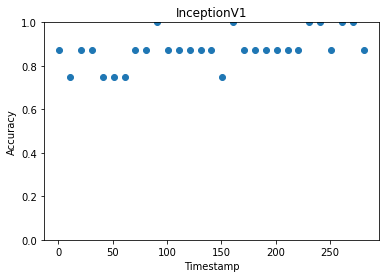

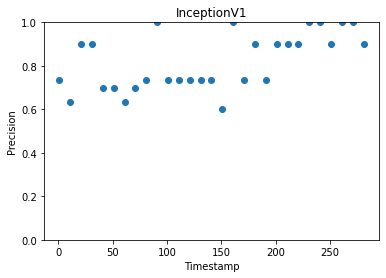

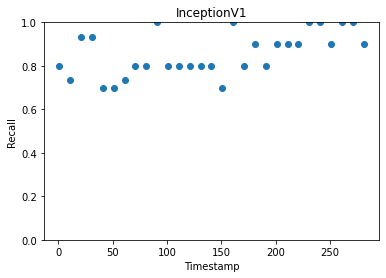

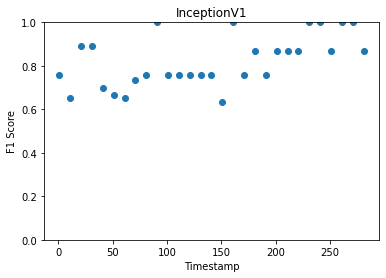

In [13]:
# print(accuracy_list)
# print(precision_list)
# print(recall_list)
# print(f1_list)
plot_metric(accuracy_list, 'Accuracy')
plot_metric(precision_list, 'Precision')
plot_metric(recall_list, 'Recall')
plot_metric(f1_list, 'F1 Score')
# Run all codes above to replicate the results, the rest is unnecessary

In [47]:
# Train the model
model = reset_model_no_freeze()
num_epochs = 100
loss_values = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(dataloaders['train']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
    
    average_loss = running_loss / len(dataloaders['train'])
    loss_values.append(average_loss)
    print(f"[Epoch {epoch+1}, Batch {i+1}] Loss: {average_loss:.3f}")      

NameError: name 'reset_model_no_freeze' is not defined

In [ ]:
import sys
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
original_stderr = sys.stderr
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
sys.stderr = open(os.devnull, 'w')
for timestamp in range(1, 290):
    print("timestamp: ", timestamp)
    dataloaders = get_dataloaders(timestamp)
    model_trained, loss_values = train_model(model, criterion, optimizer, dataloaders, num_epochs=30)
    accuracy, precision, recall, f1 = get_metrics(model_trained, dataloaders['test'])
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    print("Accuracy: ", accuracy)
    recall_list.append(recall)
    f1_list.append(f1)
sys.stderr = original_stderr

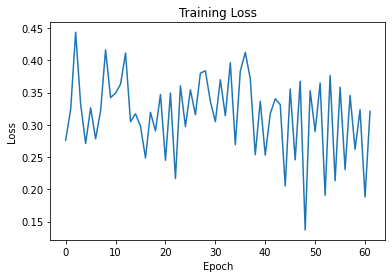

In [43]:
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
true_labels = []
predicted_labels = []
accuracy_values = []
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"tranfer no freezing 20 epochs")
print(f"accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

tranfer no freezing 20 epochs
accuracy: 0.625
Precision: 0.6833333333333333
Recall: 0.6533333333333333
F1 Score: 0.6142857142857142


In [69]:
for timestamp in range(1, 2):
# for timestamp in range(1, 10):
    print("timestamp: ", timestamp)
    dataloaders = get_dataloaders(timestamp)
    print(len(dataloaders['train'].dataset))
    print(len(dataloaders['val'].dataset))
    print(len(dataloaders['test'].dataset))

timestamp:  1
62
8
8
